In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

from sklearn.cluster import DBSCAN
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import silhouette_score
plt.rc('font', family='AppleGothic') # 한글출력
plt.rcParams['axes.unicode_minus'] = False # 축 -표시

In [187]:
train = pd.read_csv('./train_pre2.csv')
test = pd.read_csv('./test_pre2.csv')
valid = pd.read_csv('./valid_pre2.csv')

## 1. 전처리

In [188]:
# valid set의 50%를 훈련에 사용
# 시간 절약을 위해 변수선택에서는 k-fold 대신에 이 방법을 취함
split = StratifiedShuffleSplit(n_splits=1, test_size=0.5,  random_state=42)
split.get_n_splits(valid, valid['fr_yn'])

for train_index, test_index in split.split(valid, valid['fr_yn']):
    print("TRAIN:", train_index, "TEST:", test_index)
    X1, X2 = valid.iloc[train_index], valid.iloc[test_index]


train = pd.concat([train, X1], axis=0)
valid = X2

TRAIN: [4500 1321 3953 ... 1860 3015 3047] TEST: [5232  343 1494 ... 4709 3685 4497]


In [189]:
#train['lw_null'] = np.where(train['lw_13101010'].isna(), 1, 0)
#valid['lw_null'] = np.where(valid['lw_13101010'].isna(), 1, 0)
#test['lw_null'] = np.where(test['lw_13101010'].isna(), 1, 0)

In [201]:
# 예측에 쓸 변수 정의
input_var = list(set(train.columns) - set(['id','dt_of_fr','fr_yn','year']))
target = ['fr_yn']

In [191]:
# 범주형 변수명 리스트
cate_col = []
for col in train[input_var].columns:
    if (train[col].dtype == 'object'):
        cate_col.append(col)
    
cate_col = list(set(cate_col + ['month','hour','weekday','wnd_drctn']))

In [192]:
# 범주형 변수 인코딩
for col in tqdm_notebook(train.columns): 
    if col in cate_col:
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(valid[col].astype(str).values)+ list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        valid[col] = le.transform(list(valid[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))

In [193]:
# 범주형 변수 카테고리 타입으로 변경
for i in enumerate (cate_col) : 
    ca = i[1] 
    train[ca] = train[ca].astype('category') 
    valid[ca] = valid[ca].astype('category') 
    test[ca] = test[ca].astype('category') 

In [194]:
# 범주형 제외 결측은 -99로 변경
train[list(set(train.columns) - set(cate_col))] = train[list(set(train.columns) - set(cate_col))].fillna(-99)
valid[list(set(train.columns) - set(cate_col))] = valid[list(set(train.columns) - set(cate_col))].fillna(-99)
test[list(set(train.columns) - set(cate_col))] = test[list(set(train.columns) - set(cate_col))].fillna(-99)

In [197]:
from sklearn.metrics import f1_score
# LGBM 모델 평가를 위한 f1 score 정의
def lgb_f1_score(y_hat, data):
    y_true = data.get_label().astype(int)
    y_hat = np.round(y_hat).astype(int) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

In [198]:
## 전기, 가스 컬럼은 5년치 시계열 데이터의 여러가지 대푯값 변수들이라서 서로 상관관계가 매우 높다.
## 따라서 전기,가스 컬럼은 따로 변수선택을 할 것이다.

# 전기, 가스 관련 컬럼
e_col = ['e_max_01', 'e_max_02', 'e_max_03', 'e_max_04', 'e_max_05', 'e_max_06', 'e_max_07', 'e_max_08', 'e_max_09', 'e_max_10', 'e_max_11', 'e_max_12', 
         'e_mean_01', 'e_mean_02', 'e_mean_03', 'e_mean_04', 'e_mean_05', 'e_mean_06', 'e_mean_07', 'e_mean_08', 'e_mean_09', 'e_mean_10', 'e_mean_11', 'e_mean_12', 
         'e_median_01', 'e_median_02', 'e_median_03', 'e_median_04', 'e_median_05', 'e_median_06', 'e_median_07', 'e_median_08', 'e_median_09', 'e_median_10', 'e_median_11', 'e_median_12', 
         'e_min_01', 'e_min_02', 'e_min_03', 'e_min_04', 'e_min_05', 'e_min_06', 'e_min_07', 'e_min_08', 'e_min_09', 'e_min_10', 'e_min_11', 'e_min_12', 
         'e_std_01', 'e_std_02', 'e_std_03', 'e_std_04', 'e_std_05', 'e_std_06', 'e_std_07', 'e_std_08', 'e_std_09', 'e_std_10', 'e_std_11', 'e_std_12', 
         'e_va', 'ele_dday', 'ele_diff', 'ele_null'
         'g_max_01', 'g_max_02', 'g_max_03', 'g_max_04', 'g_max_05', 'g_max_06', 'g_max_07', 'g_max_08', 'g_max_09', 'g_max_10', 'g_max_11', 'g_max_12', 
         'g_mean_01', 'g_mean_02', 'g_mean_03', 'g_mean_04', 'g_mean_05', 'g_mean_06', 'g_mean_07', 'g_mean_08', 'g_mean_09', 'g_mean_10', 'g_mean_11', 'g_mean_12',
         'g_median_01', 'g_median_02', 'g_median_03', 'g_median_04', 'g_median_05', 'g_median_06', 'g_median_07', 'g_median_08', 'g_median_09', 'g_median_10', 'g_median_11', 'g_median_12',
         'g_min_01', 'g_min_02', 'g_min_03', 'g_min_04', 'g_min_05', 'g_min_06', 'g_min_07', 'g_min_08', 'g_min_09', 'g_min_10', 'g_min_11', 'g_min_12', 
         'g_std_01', 'g_std_02', 'g_std_03', 'g_std_04', 'g_std_05', 'g_std_06', 'g_std_07', 'g_std_08', 'g_std_09', 'g_std_10', 'g_std_11', 'g_std_12', 'g_va', 'gas_dday', 'gas_diff', 'gas_null']
# 그외 컬럼
exp_e= list(set(input_var) - set(e_col))

In [199]:
'''exp_e= [
    'fr_fghtng_fclt_spcl_css_6_yn','no_tbc_zn_dstnc','lw_13141010','month','weekday','lw_13121010',
 'rgnl_ar_nm2','ahsm_dstnc','emd_nm2','lw_13101211','ttl_ar','cltrl_hrtg_yn','dwn_ar','ttl_dwn_flr',
 'rgnl_ar_nm','lw_13101210','hmdt','fr_sttn_dstnc','bldng_ar_prc','prcpttn','lw_13131010','tbc_rtl_str_dstnc',
 'rd_sd_nm','tmprtr','bldng_us','lw_13111010','fr_wthr_fclt_in_100m','sft_emrgnc_bll_dstnc','jmk','cctv_dstnc',
 'mlt_us_yn','us_yn','lw_13101410','lw_13101110','lw_13121011','dt_of_athrztn','emd_nm3','fr_wthr_fclt_dstnc','dngrs_thng_yn',
'wnd_drctn','lw_13101010','wnd_spd','bldng_archtctr','bldng_cnt','lnd_ar','cctv_in_100m','hm_cnt','bldng_us_clssfctn',
 'ele_null','grnd_ar','hour','bldng_cnt_in_50m','trgt_crtr','ttl_grnd_flr','lw_13141011','lw_13111110','lw_13131110',
 'lnd_us_sttn_nm','bldng_ar','lw_13101310']'''

In [97]:
# 1차 선별
#['ttl_ar','bldng_archtctr','hmdt','bldng_cnt','lnd_us_sttn_nm','lw_13101010','rd_sd_nm','fr_wthr_fclt_in_100m','tmprtr']

['ttl_ar',
 'bldng_archtctr',
 'hmdt',
 'bldng_cnt',
 'lnd_us_sttn_nm',
 'lw_13101010',
 'rd_sd_nm',
 'fr_wthr_fclt_in_100m',
 'tmprtr',
 'ttl_dwn_flr']

In [113]:
# 에너지 컬럼 중 CV 같은 컬럼 제거한 목록 
#en_selected = pd.read_excel('./energy_selected_manual.xlsx')
#en_selected = en_selected['feature'].unique()

In [145]:
# 이래에서 전기, 가스 컬럼 변수선택 과정 진행함
#en_selected

array(['g_mean_07', 'g_max_11', 'e_median_03', 'g_max_07', 'g_median_12',
       'e_mean_10', 'g_mean_02', 'e_mean_11', 'ele_diff', 'e_median_01',
       'g_std_02', 'g_std_08', 'e_median_02', 'g_max_12', 'g_mean_04',
       'g_mean_12', 'g_mean_06', 'g_max_04', 'g_std_10', 'e_mean_09',
       'ele_dday', 'g_median_01', 'g_max_01', 'e_mean_08', 'g_std_12',
       'g_mean_10', 'gas_diff', 'e_max_10', 'e_std_09', 'g_max_05',
       'g_median_10', 'e_mean_12', 'g_median_09', 'g_mean_05', 'g_std_05',
       'e_mean_07', 'e_max_09', 'e_std_01', 'e_max_08', 'g_mean_03',
       'g_max_09', 'e_max_12', 'ele_null', 'g_mean_01', 'gas_dday',
       'e_std_02', 'g_max_06', 'g_std_11', 'e_std_08', 'g_max_03', 'g_va',
       'e_max_02', 'e_mean_03', 'g_max_02', 'e_mean_01', 'e_max_11',
       'e_mean_04', 'e_std_06', 'e_std_12', 'g_std_03', 'e_max_07',
       'e_median_08', 'e_median_09', 'e_mean_05', 'e_max_04',
       'e_median_10', 'e_median_07', 'e_max_06', 'e_std_03', 'emd_nm3',
       'e_std_0

In [203]:
len(exp_e)

61

## 변수선택

- 변수 개수 1개부터 시작하여, 각 step(=1)마다 score가 가장 높은 변수를 추가해나간다. 
- 모델 훈련에 들어가는 시간이 짧아서 가능했던 방법(한 번 해보고 싶었다. RFE로 선택한 변수는 성능이 떨어졌음)

In [204]:
from time import time
import warnings
import lightgbm
warnings.filterwarnings("ignore")

input_list = exp_e.copy() # 에너지 제외 변수 리스트 복사
cate_col2 = cate_col.copy() # 카테고리 변수 리스트 복사

allowed_time = 7.5 * 60 * 60 * 60
start_time = time()
current_time = time()

n_estimators = 10000                                                                                                                                                       
verbose = -1                                                                                                                                                            
early_stopping_rounds = 200 

# df 제작을 위해 저장할 리스트
useful_col = [] # 1차
max_features = []
max_CV = []
i = 0
# 선별 시작!
while (input_list==[]) | ((current_time - start_time) < allowed_time):
    CVs = []
    features = []
    fi = pd.DataFrame(columns=['feature','CV'])

    params = {
 'feature_fraction': 0.7659541126403374,
 'learning_rate': 0.007897842804285066,
 'baggin_freq': 3,
 'max_depth': (len(useful_col)+1)*2,
 'min_child_weight': 0.01842211053435804,
 'min_data_in_leaf': 68,
 'neg_bagging_fraction': 0.5247039559890746,
 'num_leaves': (len(useful_col)+1)*3,
 'pos_bagging_fraction': 0.2912000172840221,
 'reg_alpha': 3.0592683550829505,
 'reg_lambda': 0.6974779083216026,
 'is_unbalance': True,
 'use_missing':True,
         # 'device' : 'gpu'
          }
    params['objective'] = 'binary'
    params['metric'] = 'None'
    params['verbose'] = -1
    params['boosting_type'] = 'gbdt'
    params['random_state'] = 47
    
    for col in input_list:
      add_columns = useful_col + [col] # 1개씩 테스트
      cate_col2 = list(set(cate_col) & set(add_columns))
      # 모델 학습
      X_train, X_valid = train[add_columns], valid[add_columns]
      y_train, y_valid = train['fr_yn'], valid['fr_yn']
      dtrain = lgb.Dataset(X_train, label=y_train)
      dvalid = lgb.Dataset(X_valid, label=y_valid)
      model = lgb.train(params, dtrain, n_estimators, valid_sets=[dtrain, dvalid], feval= lgb_f1_score,
                        verbose_eval=-1, early_stopping_rounds=early_stopping_rounds,
                        categorical_feature = cate_col2)
      features.append(col)
      CVs.append(model.best_score["valid_1"]["f1"] )
    
    # 결과 정리
    fi['feature'] = features
    fi['CV'] = CVs

    CV = fi.loc[fi['CV'].idxmax()]['CV'] # 최고 CV
    feature = fi.iloc[fi['CV'].idxmax()]['feature'] # 최고 feature

    input_list.remove(feature) # 인풋 컬럼 제거
    useful_col.append(feature) # 사용할 컬럼 추가
    # 결과 저장
    max_features.append(feature)
    max_CV.append(CV)
    
    print('************************************************* Mean AUC:', CV, ', ', X_train.shape[1], feature)
    # 카테고리 변수 리스트 업데이트
    if feature in cate_col2: 
      cate_col2.remove(feature)
    
    # CV 향상 안되면 종료
    if (i>=1) & (max_CV[i-1]- max_CV[i]>0.01):
        break
    i=i+1
    current_time = time()

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[185]	training's f1: 0.201121	valid_1's f1: 0.195238
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[449]	training's f1: 0.269244	valid_1's f1: 0.0516605
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[85]	training's f1: 0.0426123	valid_1's f1: 0.119534
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's f1: 0	valid_1's f1: 0
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's f1: 0	valid_1's f1: 0
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[86]	training's f1: 0.0399211	valid_1's f1: 0.119534
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's f1: 0	valid_1's f1:

[86]	training's f1: 0.0412754	valid_1's f1: 0.119534
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[85]	training's f1: 0.0430556	valid_1's f1: 0.119534
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[121]	training's f1: 0.329727	valid_1's f1: 0.409213
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[140]	training's f1: 0.345541	valid_1's f1: 0.438911
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[86]	training's f1: 0.0423807	valid_1's f1: 0.119534
************************************************* Mean AUC: 0.4664914586070959 ,  1 ttl_ar
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[136]	training's f1: 0.341001	valid_1's f1: 0.466491
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[145]	tra

[116]	training's f1: 0.395955	valid_1's f1: 0.489418
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[119]	training's f1: 0.400652	valid_1's f1: 0.496542
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[118]	training's f1: 0.420104	valid_1's f1: 0.48829
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[108]	training's f1: 0.390167	valid_1's f1: 0.486919
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[108]	training's f1: 0.385868	valid_1's f1: 0.49483
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[102]	training's f1: 0.382339	valid_1's f1: 0.493604
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[116]	training's f1: 0.408661	valid_1's f1: 0.508909
Training until validation scores don't improve fo

[103]	training's f1: 0.394749	valid_1's f1: 0.505095
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[110]	training's f1: 0.41598	valid_1's f1: 0.512855
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[97]	training's f1: 0.382166	valid_1's f1: 0.506289
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[105]	training's f1: 0.389832	valid_1's f1: 0.510993
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[103]	training's f1: 0.376094	valid_1's f1: 0.508772
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[105]	training's f1: 0.388862	valid_1's f1: 0.510542
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[102]	training's f1: 0.402109	valid_1's f1: 0.508475
Training until validation scores don't improve fo

[108]	training's f1: 0.429663	valid_1's f1: 0.522064
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[105]	training's f1: 0.412386	valid_1's f1: 0.522637
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[105]	training's f1: 0.412704	valid_1's f1: 0.522637
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[112]	training's f1: 0.446826	valid_1's f1: 0.522238
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[102]	training's f1: 0.410822	valid_1's f1: 0.52057
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[107]	training's f1: 0.433548	valid_1's f1: 0.5204
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[103]	training's f1: 0.440445	valid_1's f1: 0.519273
Training until validation scores don't improve for

[101]	training's f1: 0.430018	valid_1's f1: 0.535559
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[101]	training's f1: 0.4308	valid_1's f1: 0.534682
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[101]	training's f1: 0.4308	valid_1's f1: 0.534682
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[101]	training's f1: 0.4308	valid_1's f1: 0.534682
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[99]	training's f1: 0.428516	valid_1's f1: 0.531868
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[101]	training's f1: 0.430624	valid_1's f1: 0.532084
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[96]	training's f1: 0.432341	valid_1's f1: 0.530642
Training until validation scores don't improve for 200 

[100]	training's f1: 0.435982	valid_1's f1: 0.527897
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[99]	training's f1: 0.418794	valid_1's f1: 0.534236
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[95]	training's f1: 0.406737	valid_1's f1: 0.529501
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[100]	training's f1: 0.421731	valid_1's f1: 0.535928
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[100]	training's f1: 0.421053	valid_1's f1: 0.535232
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[100]	training's f1: 0.422562	valid_1's f1: 0.536732
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[98]	training's f1: 0.423211	valid_1's f1: 0.533835
Training until validation scores don't improve for

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[99]	training's f1: 0.418849	valid_1's f1: 0.540377
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[98]	training's f1: 0.425717	valid_1's f1: 0.537023
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[100]	training's f1: 0.431428	valid_1's f1: 0.529964
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[98]	training's f1: 0.41515	valid_1's f1: 0.53651
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[100]	training's f1: 0.437485	valid_1's f1: 0.52479
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[98]	training's f1: 0.418702	valid_1's f1: 0.52479
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[98]	traini

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[98]	training's f1: 0.419757	valid_1's f1: 0.536067
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[98]	training's f1: 0.419757	valid_1's f1: 0.536067
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[98]	training's f1: 0.419757	valid_1's f1: 0.536067
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[98]	training's f1: 0.419757	valid_1's f1: 0.536067
************************************************* Mean AUC: 0.5378151260504201 ,  14 cctv_in_100m
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[108]	training's f1: 0.468878	valid_1's f1: 0.526773
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[99]	training's f1: 0.417245	valid_1's f1: 0.535687
Trainin

[100]	training's f1: 0.434107	valid_1's f1: 0.538757
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[100]	training's f1: 0.434107	valid_1's f1: 0.538757
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[101]	training's f1: 0.441617	valid_1's f1: 0.534831
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[103]	training's f1: 0.456852	valid_1's f1: 0.528384
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[100]	training's f1: 0.434107	valid_1's f1: 0.538757
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[100]	training's f1: 0.434431	valid_1's f1: 0.539464
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[100]	training's f1: 0.432785	valid_1's f1: 0.541122
Training until validation scores don't improve 

[99]	training's f1: 0.439114	valid_1's f1: 0.539413
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[99]	training's f1: 0.432711	valid_1's f1: 0.539104
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[99]	training's f1: 0.434831	valid_1's f1: 0.538813
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[99]	training's f1: 0.433645	valid_1's f1: 0.539394
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[99]	training's f1: 0.435258	valid_1's f1: 0.540458
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[99]	training's f1: 0.435258	valid_1's f1: 0.540458
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[99]	training's f1: 0.435258	valid_1's f1: 0.540458
Training until validation scores don't improve for 200

[101]	training's f1: 0.441579	valid_1's f1: 0.534134
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[101]	training's f1: 0.441579	valid_1's f1: 0.534134
************************************************* Mean AUC: 0.5365126676602087 ,  20 rgnl_ar_nm
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[107]	training's f1: 0.490014	valid_1's f1: 0.522675
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[100]	training's f1: 0.439655	valid_1's f1: 0.537425
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[100]	training's f1: 0.439655	valid_1's f1: 0.537425
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[100]	training's f1: 0.439655	valid_1's f1: 0.537425
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[100

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[97]	training's f1: 0.442297	valid_1's f1: 0.528551
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[100]	training's f1: 0.440795	valid_1's f1: 0.53434
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[100]	training's f1: 0.440731	valid_1's f1: 0.533434
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[99]	training's f1: 0.44398	valid_1's f1: 0.530488
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[101]	training's f1: 0.450279	valid_1's f1: 0.531479
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[103]	training's f1: 0.467259	valid_1's f1: 0.522963
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[102]	t

[101]	training's f1: 0.453942	valid_1's f1: 0.531571
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[101]	training's f1: 0.453942	valid_1's f1: 0.531571
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[98]	training's f1: 0.432719	valid_1's f1: 0.530421
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[102]	training's f1: 0.463554	valid_1's f1: 0.528653
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[101]	training's f1: 0.453942	valid_1's f1: 0.531571
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[101]	training's f1: 0.453942	valid_1's f1: 0.531571
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[100]	training's f1: 0.44737	valid_1's f1: 0.533534
Training until validation scores don't improve fo

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[97]	training's f1: 0.430617	valid_1's f1: 0.528185
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[97]	training's f1: 0.430617	valid_1's f1: 0.528185
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[98]	training's f1: 0.439418	valid_1's f1: 0.528388
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[100]	training's f1: 0.461492	valid_1's f1: 0.532164
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[97]	training's f1: 0.430617	valid_1's f1: 0.528185
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[97]	training's f1: 0.430617	valid_1's f1: 0.528185
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[98]	tra

[95]	training's f1: 0.440941	valid_1's f1: 0.530156
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[95]	training's f1: 0.441687	valid_1's f1: 0.528839
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[95]	training's f1: 0.44238	valid_1's f1: 0.52782
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[94]	training's f1: 0.43423	valid_1's f1: 0.52459
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[95]	training's f1: 0.441721	valid_1's f1: 0.533333
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[95]	training's f1: 0.442112	valid_1's f1: 0.530337
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[95]	training's f1: 0.441687	valid_1's f1: 0.528839
Training until validation scores don't improve for 200 rou

[95]	training's f1: 0.441573	valid_1's f1: 0.528667
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[95]	training's f1: 0.441573	valid_1's f1: 0.528667
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[95]	training's f1: 0.441573	valid_1's f1: 0.528667
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[95]	training's f1: 0.441573	valid_1's f1: 0.528667
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[95]	training's f1: 0.443647	valid_1's f1: 0.529889
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[95]	training's f1: 0.441195	valid_1's f1: 0.52608
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[95]	training's f1: 0.441573	valid_1's f1: 0.528667
Training until validation scores don't improve for 200 

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[98]	training's f1: 0.471743	valid_1's f1: 0.521212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[95]	training's f1: 0.444267	valid_1's f1: 0.526156
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[95]	training's f1: 0.444267	valid_1's f1: 0.526156
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[95]	training's f1: 0.444267	valid_1's f1: 0.526156
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[95]	training's f1: 0.444267	valid_1's f1: 0.526156
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[95]	training's f1: 0.444267	valid_1's f1: 0.526156
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[95]	trai

[97]	training's f1: 0.462193	valid_1's f1: 0.525937
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[96]	training's f1: 0.456096	valid_1's f1: 0.515885
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[95]	training's f1: 0.445437	valid_1's f1: 0.527423
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[95]	training's f1: 0.445894	valid_1's f1: 0.52819
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[97]	training's f1: 0.462193	valid_1's f1: 0.525937
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[97]	training's f1: 0.462193	valid_1's f1: 0.525937
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[97]	training's f1: 0.462193	valid_1's f1: 0.525937
Training until validation scores don't improve for 200 

[97]	training's f1: 0.46522	valid_1's f1: 0.527076
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[97]	training's f1: 0.46522	valid_1's f1: 0.527076
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[94]	training's f1: 0.44405	valid_1's f1: 0.516588
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[97]	training's f1: 0.46522	valid_1's f1: 0.527076
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[97]	training's f1: 0.46522	valid_1's f1: 0.527076
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[97]	training's f1: 0.46522	valid_1's f1: 0.527076
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[97]	training's f1: 0.46522	valid_1's f1: 0.527076
************************************************* Mean AUC: 0

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[108]	training's f1: 0.546276	valid_1's f1: 0.518224
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[108]	training's f1: 0.546276	valid_1's f1: 0.518224
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[108]	training's f1: 0.546276	valid_1's f1: 0.518224
************************************************* Mean AUC: 0.5182239893969516 ,  58 lw_13111110
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[105]	training's f1: 0.535225	valid_1's f1: 0.51773
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[101]	training's f1: 0.506476	valid_1's f1: 0.52161
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[101]	training's f1: 0.506476	valid_1's f1: 0.52161
******

ValueError: attempt to get argmax of an empty sequence

In [205]:
# 결과 저장
fe = pd.DataFrame(columns=['added_feature','CV','columns'])
fe['added_feature']=max_features
fe['CV']=max_CV
fe['columns'] = useful_col
fe['N_added'] = range(fe.shape[0])

fe

,added_feature,CV,columns,N_added
0,ttl_ar,0.466491,ttl_ar,0
1,g_max_01,0.499659,g_max_01,1
2,wnd_spd,0.511628,wnd_spd,2
3,bldng_cnt,0.513353,bldng_cnt,3
4,hour,0.518359,hour,4
5,hmdt,0.522957,hmdt,5
6,bldng_ar,0.531049,bldng_ar,6
7,month,0.536515,month,7
8,lnd_us_sttn_nm,0.537700,lnd_us_sttn_nm,8
9,prcpttn,0.536364,prcpttn,9


In [207]:
fe.to_csv('blg_feature_select.csv',index=False)

In [212]:
fe.iloc[:37].added_feature.unique()

array(['ttl_ar', 'g_max_01', 'wnd_spd', 'bldng_cnt', 'hour', 'hmdt',
       'bldng_ar', 'month', 'lnd_us_sttn_nm', 'prcpttn', 'jmk', 'dwn_ar',
       'fr_fghtng_fclt_spcl_css_6_yn', 'cctv_in_100m', 'emd_nm2',
       'ttl_dwn_flr', 'wnd_drctn', 'bldng_cnt_in_50m', 'rd_sd_nm',
       'rgnl_ar_nm', 'lw_13141010', 'ttl_grnd_flr', 'cltrl_hrtg_yn',
       'mlt_us_yn', 'tbc_rtl_str_dstnc', 'bldng_us', 'emd_nm3',
       'ahsm_dstnc', 'fr_wthr_fclt_dstnc', 'lnd_ar', 'cctv_dstnc',
       'bldng_us_clssfctn', 'fr_sttn_dstnc', 'bldng_ar_prc', 'tmprtr',
       'us_yn', 'bldng_archtctr'], dtype=object)

In [206]:
from bokeh.models import HoverTool
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
# 시각화
output_notebook()

fig = figure(plot_height=700,
             plot_width=900,
             x_axis_label='Number of added features',
             x_range=(0, fe.shape[0]),
             y_axis_label='f1',
             title='f1 vs number of added features',
             toolbar_location='below',
             tools='save, box_zoom, pan, wheel_zoom, reset')

tooltips = [
            ('added feature','@added_feature'),
            ('CV change', '@CV_change'),
            ("Number of added features", "@N_added"),
            ("Current CV", "@CV")
           ]

scatter = fig.circle(x='N_added', y='CV', source=fe,
        size=10, alpha=1,
        hover_fill_color='cyan', hover_alpha=0.3)

fig.add_tools(HoverTool(tooltips=tooltips, renderers=[scatter]))

show(fig)

Loading BokehJS ...

- 최고점수는 변수 개수 17개인 때였지만, 변수 개수가 적으면 test에서 성능이 떨어지는 문제가 있었다.
    - valid set의 크기가 작아서, test에 일반화되지 않았던 것 같다.
    
    
- 이를 보완하기 위해 최대한 성능이 높으면서 변수 개수도 많은 지점을 선정했다. = 변수 37개 지점

In [210]:
fe.added_feature

0                           ttl_ar
1                         g_max_01
2                          wnd_spd
3                        bldng_cnt
4                             hour
5                             hmdt
6                         bldng_ar
7                            month
8                   lnd_us_sttn_nm
9                          prcpttn
10                             jmk
11                          dwn_ar
12    fr_fghtng_fclt_spcl_css_6_yn
13                    cctv_in_100m
14                         emd_nm2
15                     ttl_dwn_flr
16                       wnd_drctn
17                bldng_cnt_in_50m
18                        rd_sd_nm
19                      rgnl_ar_nm
20                     lw_13141010
21                    ttl_grnd_flr
22                   cltrl_hrtg_yn
23                       mlt_us_yn
24               tbc_rtl_str_dstnc
25                        bldng_us
26                         emd_nm3
27                      ahsm_dstnc
28              fr_w

# 에너지 1차 선별( 위 과정 반복)

In [1]:
from time import time
import warnings
import lightgbm
warnings.filterwarnings("ignore")

input_list = energy.copy() # 에너지 제외 변수 리스트 복사
cate_col2 = cate_col.copy() # 카테고리 변수 리스트 복사

allowed_time = 7.5 * 60 * 60 * 60
start_time = time()
current_time = time()

n_estimators = 10000                                                                                                                                                       
verbose = -1                                                                                                                                                            
early_stopping_rounds = 200 

# df 제작을 위해 저장할 리스트
useful_col2 = exp_e.copy()
max_features = []
max_CV = []
i = 0
while (input_list==[]) | ((current_time - start_time) < allowed_time):
    CVs = []
    features = []
    fi = pd.DataFrame(columns=['feature','CV'])

    params = {'bagging_fraction': 0.8759278817295955,
 'feature_fraction': 0.7659541126403374,
 'learning_rate': 0.007897842804285066,
 #'learning_rate': 0.03,
 'max_depth': (len(useful_col)+1)*2,
 'min_child_weight': 0.01842211053435804,
 'min_data_in_leaf': 68,
 'neg_bagging_fraction': 0.5247039559890746,
 'num_leaves': (len(useful_col)+1)*3,
 'pos_bagging_fraction': 0.2912000172840221,
 'reg_alpha': 3.0592683550829505,
 'reg_lambda': 0.6974779083216026,
 'is_unbalance': True,
         'use_missing':True,
         # 'device' : 'gpu'
          }
    params['objective'] = 'binary'
    params['metric'] = 'None'
    params['verbose'] = -1
    params['boosting_type'] = 'gbdt'
    params['random_state'] = 47
    
    for col in input_list:
      add_columns = useful_col2 + [col] # 1개씩 테스트
      cate_col2 = list(set(cate_col) & set(add_columns))
      # 모델 학습
      X_train, X_valid = train[add_columns], valid[add_columns]
      y_train, y_valid = train['fr_yn'], valid['fr_yn']
      dtrain = lgb.Dataset(X_train, label=y_train)
      dvalid = lgb.Dataset(X_valid, label=y_valid)
      model = lgb.train(params, dtrain, n_estimators, valid_sets=[dtrain, dvalid], feval= lgb_f1_score,
                        verbose_eval=-1, early_stopping_rounds=early_stopping_rounds,
                        categorical_feature = cate_col2)
      features.append(col)
      CVs.append(model.best_score["valid_1"]["f1"] )
    
    # 결과 정리
    fi['feature'] = features
    fi['CV'] = CVs
    break
    CV = fi.loc[fi['CV'].idxmax()]['CV'] # 최고 CV
    feature = fi.iloc[fi['CV'].idxmax()]['feature'] # 최고 feature

    input_list.remove(feature) # 인풋 컬럼 제거
    useful_col2.append(feature) # 사용할 컬럼 추가
    
    # 결과 저장
    max_features.append(feature)
    max_CV.append(CV)
    
    print('************************************************* Mean AUC:', CV, ', ', X_train.shape[1], feature)
    # 카테고리 변수 리스트 업데이트
    if feature in cate_col2: 
      cate_col2.remove(feature)
    
    # CV 향상 안되면 종료
    if (i>=1) & (max_CV[i-1]>max_CV[i]):
        break
    i=i+1
    current_time = time()

KeyboardInterrupt: 

In [81]:
fi.groupby(['feature','CV']).sum()

,
feature,CV
e_max_01,0.531250
e_max_02,0.529494
e_max_03,0.525469
e_max_04,0.528226
e_max_05,0.531250
e_max_06,0.527532
e_max_07,0.528581
e_max_08,0.530471
e_max_09,0.530780


In [96]:
fi.to_csv('elec_select.csv',index=False)

# 테스트용 예측

- 가장 순위가 높은 9개 변수에 대해서만 시험용으로 예측을 해보았다.

In [84]:
useful_col[:-1]

['ttl_ar',
 'bldng_archtctr',
 'hmdt',
 'bldng_cnt',
 'lnd_us_sttn_nm',
 'lw_13101010',
 'rd_sd_nm',
 'fr_wthr_fclt_in_100m',
 'tmprtr']

In [91]:
params = {'bagging_fraction': 0.8759278817295955,
 'feature_fraction': 0.7659541126403374,
 'learning_rate': 0.007897842804285066,
 #'learning_rate': 0.03,
 'max_depth': (len(useful_col[:-1])),
 'min_child_weight': 0.01842211053435804,
 'min_data_in_leaf': 68,
 'neg_bagging_fraction': 0.5247039559890746,
 'num_leaves': (len(useful_col[:-1]))*2,
 'pos_bagging_fraction': 0.2912000172840221,
 'reg_alpha': 3.0592683550829505,
 'reg_lambda': 0.6974779083216026,
 'is_unbalance': True,
         'use_missing':True,
         # 'device' : 'gpu'
          }
params['objective'] = 'binary'
params['metric'] = 'None'
params['verbose'] = -1
params['boosting_type'] = 'gbdt'
params['random_state'] = 47

In [92]:
X_train =train[useful_col[:-1]]
X_valid = valid[useful_col[:-1]]
lgb_train = lgb.Dataset(X_train,
                           label = y_train
                           )
lgb_valid = lgb.Dataset(X_valid,
                           label = y_valid
                           )
clf = lgb.train(params, lgb_train, 10000, valid_sets = [lgb_train, lgb_valid], feval= lgb_f1_score,
                         verbose_eval=100, early_stopping_rounds = 100, categorical_feature =list(set(cate_col) & set(useful_col[:-1])))

Training until validation scores don't improve for 100 rounds
[100]	training's f1: 0.399467	valid_1's f1: 0.526393
[200]	training's f1: 0.497062	valid_1's f1: 0.429693
Early stopping, best iteration is:
[104]	training's f1: 0.422784	valid_1's f1: 0.535368


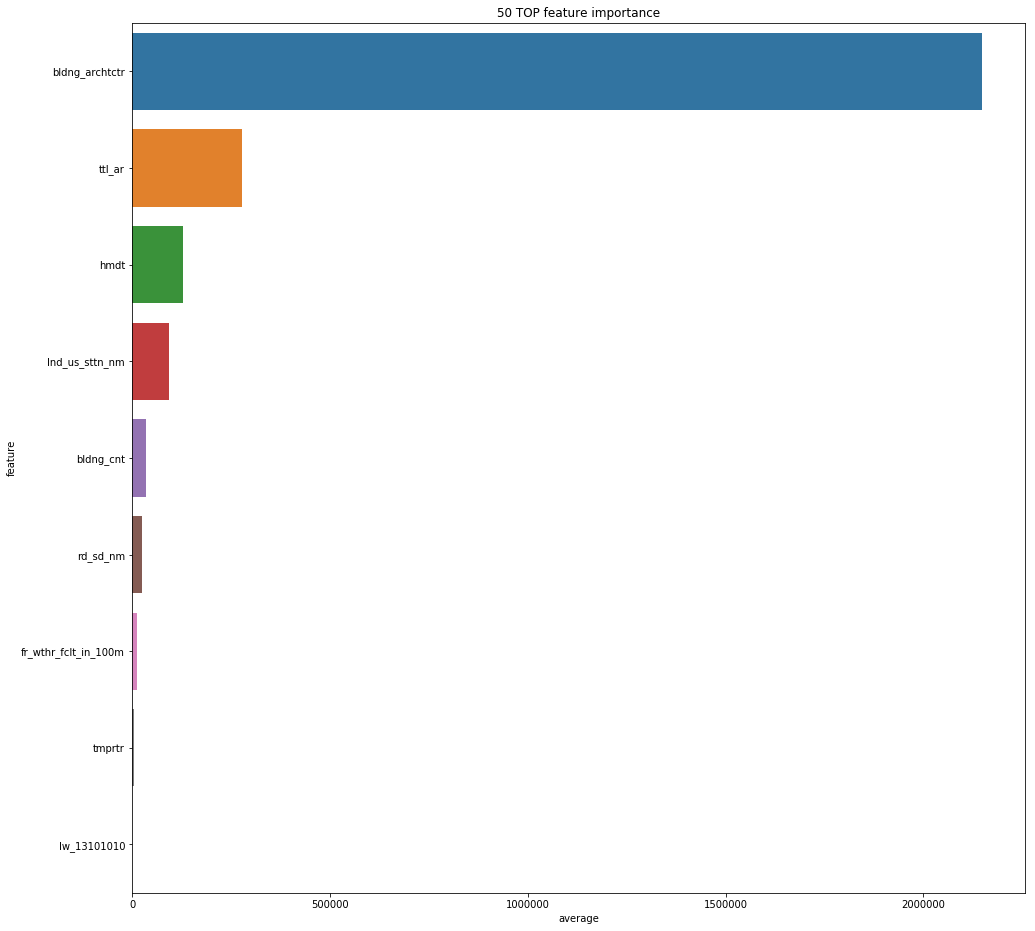

In [93]:
feature_importances = pd.DataFrame()
feature_importances['feature'] = X_train.columns

feature_importances['fold_{}'.format(1)] = clf.feature_importance(importance_type='gain')
feature_importances['average'] = feature_importances[['fold_{}'.format(1) for fold in range(1)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance');

- valid 상에서는 기존과 비슷한 성능이 나왔다.
- 하지만 test 상에서는 다소 f1 score가 낮아졌다(0.485).
- 그래도 이 정도 성능이면, 꽤 높은 편

In [94]:
submission = pd.read_csv('./PJT002_submission.csv')
submission['fr_yn'] = clf.predict(test[list(X_train.columns)])
submission['fr_yn'] = np.where(submission['fr_yn']>=0.5, 'Y', 'N')
submission[submission['fr_yn']=='N'].shape[0] / submission.shape[0]

0.7872844098748731

In [95]:
submission.to_csv('ajk2000000_화재예측과제_Submission1211_fe_half.csv', index=False)# v=0.535368, 0.50251: valid 절반 떼어줌

### 결론

- RFE보다 변수 선택이 잘 되었다.
- 하지만 무식?한 방법이기에 보통은 시간 소모가 매우 커서 불가능한 방법이다.
- 아무튼 이번 대회에서는 이렇게 선택된 변수로 최종 모델링을 진행했다.